# Boilerplate

In [1]:
from fastai.tabular import *
from fastai.text import *
from fastai.vision import Path
import torch.nn.utils.rnn as trnn
import numpy as np
from IPython.core.debugger import set_trace

# Custom collate_fn to get sequence data

In [2]:
def sequence_collate(batch):
    '''Function that collects `samples` of tabular lines and reshapes them to RNN Sequences of seq_length.'''
    # x.shape -> BSx10 | y.shape -> BS x 1
    x, y = data_collate(batch)    
    #One-Hot encode result(y, True/False) and add it as last sequence
    size = y.size(0)
    enc = torch.zeros(size, 2)
    for i in range(size):
        enc[i][y[i]] = 1

    # Input is now BSX12
    x[1] = torch.cat((x[1], enc),dim=1)    
    # Resize input from BSx12 into paired sequences
    # -> x.shape = (BSx6x2)
    x[1] = x[1].reshape(x[1].size(0), math.ceil(x[1].size(1)/2),-1)
    return [x, y]

## Load Data

In [3]:
gender = 'men'
file = 'normalized_' + gender + '.csv'
path = Path('data')

In [4]:
df = pd.read_csv(path/file)

In [5]:
dep_var = 'Success'
cat_names = ['Tech', 'Direction']
cont_with_def = ['Serve_X', 'Serve_Y', 'Reception_X', 'Reception_Y', 'Set_X', 'Set_Y', 'Inrun_X', 'Inrun_Y', 'Attack_X', 'Attack_Y', 'Defense_X', 'Defense_Y']
cont_without_def = ['Serve_X', 'Serve_Y', 'Reception_X', 'Reception_Y', 'Set_X', 'Set_Y', 'Inrun_X', 'Inrun_Y', 'Attack_X', 'Attack_Y']
procs = [FillMissing, Categorify]
data_df = df.drop(cat_names, 1)

In [6]:
# Create Databunch
# Split by idx because randn_perc for some reason does not respect the drop_last property in the valid_dl
# even if set explicitly.
# This results in an error at validation time, because the last batch has not the right dimensions for the RNN
data = (TabularList.from_df(df, path=path, cont_names=cont_without_def, procs=procs)
                           .split_by_idx(list(range(0,2560)))
                           .label_from_df(cols=dep_var)
                           .databunch(collate_fn=sequence_collate))

data.valid_dl.drop_last = True

In [7]:
# Confim the size of the last batch that causes the validation error
math.floor(len(df)*0.2) - (math.floor(len(df)*0.2 / 64)*64)

17

# Hyperparameters

In [8]:
BATCH_SIZE = 16
TIME_STEP = 5
INPUT_SIZE = 2
HIDDEN_LAYERS = 128
OUTPUT_DIM = 2

## Multi-layer GRU

### Custom Loss and Metrics

In [9]:
def lossLast(input,target): 
    size = input.size(0)
    
    # One-hot encode targets again, since CrossEntropy expects a vector with 1 element per class
    enc = torch.zeros(size, 2, dtype=torch.long).cuda()
    for i in range(size):
        enc[i][target[i]] = 1
        
    # CrossEntropy with only last hidden state not possible??
    #last = torch.stack([input[i][-1] for i in range(size)])   
    loss = nn.CrossEntropyLoss()
    return loss(input, enc)


def accLast (input,target):
    size = input.size(0)
    r = range(size)
    # Only take the last hidden layer
    last = torch.stack([input[i][-1] for i in r])
    # Apply softmax
    m = nn.Softmax(dim=1)
    soft_last = m(last)
    return accuracy(soft_last, target)

### Model

In [10]:
class beachGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bs, gru_layers):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, gru_layers, batch_first=True)
        self.h_o = nn.Linear(hidden_dim, output_dim)
        self.bn = BatchNorm1dFlat(hidden_dim)
        # Not necessary anymore
        #self.h = torch.zeros(gru_layers, bs, hidden_dim).cuda()
        
    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        #res,h = self.gru(x_cont, self.h)
        res,_ = self.gru(x_cont)
        #self.h = h.detach()
        return self.h_o(self.bn(res))

In [11]:
learn = Learner(data, beachGRU(INPUT_SIZE, HIDDEN_LAYERS, OUTPUT_DIM, BATCH_SIZE, 2), loss_func=lossLast, metrics=accLast)

### Training

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


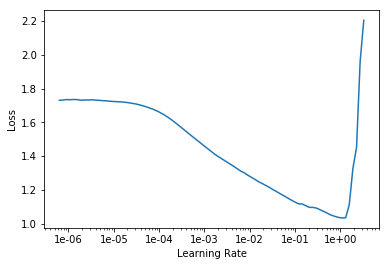

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accLast,time
0,0.860697,0.828689,0.386328,00:02
1,0.691466,0.681910,0.612109,00:02
2,0.665408,0.668878,0.361719,00:02
3,0.662216,0.671588,0.608203,00:02
4,0.663629,0.667944,0.612891,00:02
5,0.663024,0.668828,0.613672,00:02
6,0.661508,0.668662,0.613672,00:02
7,0.662463,0.668473,0.613672,00:02
8,0.663864,0.667366,0.613672,00:02
9,0.662302,0.667428,0.613672,00:02
